In [2]:
import pandas as pd
import pickle
import numpy as np
import nltk
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/student/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
with open('team5_data.pkl', 'rb') as file:
    df = pickle.load(file)

Index(['image_link', 'temperature', 'description', 'logits', 'hallucinations',
       'hedges', 'probe_1', 'label_1', 'pred_1', 'context_1', 'probe_2',
       'label_2', 'pred_2', 'context_2', 'probe_3', 'label_3', 'pred_3',
       'context_3', 'probe_4', 'label_4', 'pred_4', 'context_4', 'pred_1_prob',
       'pred_2_prob', 'pred_3_prob', 'pred_4_prob', 'hallucinations_count',
       'hedges_count', 'context_1_count', 'context_2_count', 'context_3_count',
       'context_4_count', 'clean_description', 'description_len',
       'first_hal_index', 'hal_lens', 'words_logits_mapping', 'in_out_probs',
       'in_out_random_probs', 'in_out_pairs_ratio_probs', 'out_probs',
       'in_probs', 'out_random_probs', 'in_random_probs'],
      dtype='object')

In [4]:
def get_pos_tags(words_logits_mapping):
    # Tokenize each sentence and perform POS tagging
    tokens = [maping[0] for maping in words_logits_mapping]
    # Use NLTK's default POS tagger
    tagged = nltk.pos_tag(tokens)
    return tagged

df['POS'] = df['words_logits_mapping'].apply(lambda words_logits_mapping: get_pos_tags(words_logits_mapping))

In [5]:
def clean_text(text):
    # Remove specific substrings
    text = re.sub(r'<0x0A>', ' ', text)
    text = re.sub(r'</s>', '', text)
    # Remove any other unwanted patterns (adjust the regex if needed)
    text = re.sub(r'<[^>]*>', '', text)
    return text.strip()

def get_in_out_indices(halucination):
    clean_hal = clean_text(halucination)
    in_indices = []
    out_indices = []
    words = clean_hal.split()
    in_brackets = False
    for i, word in enumerate(words):
        if '[' in word:
            in_brackets = True
        if ']' in word:
            in_brackets = False

        if in_brackets or '[' in word or ']' in word:
            in_indices.append(i)
        else:
            out_indices.append(i)
    return {'in': in_indices, 'out': out_indices}

df['in_out_indices'] = df['hallucinations'].apply(lambda hal: get_in_out_indices(hal))

In [12]:
def combine_word_pos_prob(words_logits_mapping, POS, in_out_indices, logits, index):
    in_pos = []
    out_pos = []
    for word_index, (word_mapping, pos) in enumerate(zip(words_logits_mapping, POS)):
        if word_mapping[0] != pos[0]:
            print('Warning! 1', index)
            print(word_mapping , pos)
            print('-'*150)
        else:
            if word_index in in_out_indices['in']:
                prob = logits[word_mapping[1][0]][1][logits[word_mapping[1][0]][0].strip()]
                in_pos.append((word_mapping[0], pos[1], prob))
            elif word_index in in_out_indices['out']:
                prob = logits[word_mapping[1][0]][1][logits[word_mapping[1][0]][0].strip()]
                out_pos.append((word_mapping[0], pos[1], prob))
            else:
                print('Warning! 2', index)
                print(words_logits_mapping)
                print(in_out_indices['in'])
                print(in_out_indices['out'])
                print(word_mapping)
                print('-'*150)
    return {'in':in_pos, 'out':out_pos}

df['index'] = [i for i in range(len(df))]
df['combine_word_pos_prob'] = df.apply(lambda row:combine_word_pos_prob(row['words_logits_mapping'], row['POS'], row['in_out_indices'], row['logits'], row['index']),axis=1)
df['combine_word_pos_prob']

0      {'in': [('moving', 'VBG', 0.0203)], 'out': [('...
1      {'in': [('two', 'CD', 0.2512), ('children', 'N...
2      {'in': [('bird,', 'NN', 0.1201)], 'out': [('Th...
3      {'in': [('two', 'CD', 0.1047), ('dogs', 'NNS',...
4      {'in': [('cityscape', 'NN', 0.0139)], 'out': [...
                             ...                        
145    {'in': [('dining', 'VBG', 0.3381), ('another',...
146    {'in': [('cooler', 'NN', 0.1197)], 'out': [('T...
147    {'in': [('six', 'CD', 0.2216), ('three', 'CD',...
148    {'in': [('flowers,', 'NN', 0.0052), ('bead', '...
149    {'in': [('brown', 'JJ', 0.0012), ('five', 'CD'...
Name: combine_word_pos_prob, Length: 150, dtype: object

In [13]:
# # Organize data by POS tag
# pos_probs = {}
# for combine_word_pos_prob in df['combine_word_pos_prob']:
#     for category in combine_word_pos_prob.values():
#         for word, pos, prob in category:
#             if pos not in pos_probs:
#                 pos_probs[pos] = []
#             pos_probs[pos].append(prob)

# # Plot histograms for each POS tag
# plt.figure(figsize=(12, 8))

# for pos, probs in pos_probs.items():
#     plt.figure(figsize=(10, 6))
#     sns.histplot(probs, kde=False, bins=10, label=pos)
#     plt.title(f'Histogram of Probabilities for POS Tag: {pos}')
#     plt.xlabel('Probability')
#     plt.ylabel('Frequency')
#     plt.legend()
#     plt.show()

In [9]:
# # Organize data by POS tag for 'in' and 'out' categories
# pos_probs_in = {}
# pos_probs_out = {}

# for combine_word_pos_prob in df['combine_word_pos_prob']:
#     for category, pos_probs in combine_word_pos_prob.items():
#         for word, pos, prob in pos_probs:
#             if category == 'in':
#                 if pos not in pos_probs_in:
#                     pos_probs_in[pos] = []
#                 pos_probs_in[pos].append(prob)
#             elif category == 'out':
#                 if pos not in pos_probs_out:
#                     pos_probs_out[pos] = []
#                 pos_probs_out[pos].append(prob)

# # Plot histograms for each POS tag comparison between 'in' and 'out'
# plt.figure(figsize=(14, 10))

# # Get all unique POS tags
# all_pos_tags = set(pos_probs_in.keys()).union(pos_probs_out.keys())

# for pos in all_pos_tags:
#     plt.figure(figsize=(12, 6))
#     sns.histplot(pos_probs_in.get(pos, []), kde=False, bins=10, label=f'{pos} - in', color='blue', alpha=0.6)
#     sns.histplot(pos_probs_out.get(pos, []), kde=False, bins=10, label=f'{pos} - out', color='red', alpha=0.6)
#     plt.title(f'Histogram of Probabilities for POS Tag: {pos}')
#     plt.xlabel('Probability')
#     plt.ylabel('Frequency')
#     plt.legend()
#     plt.show()

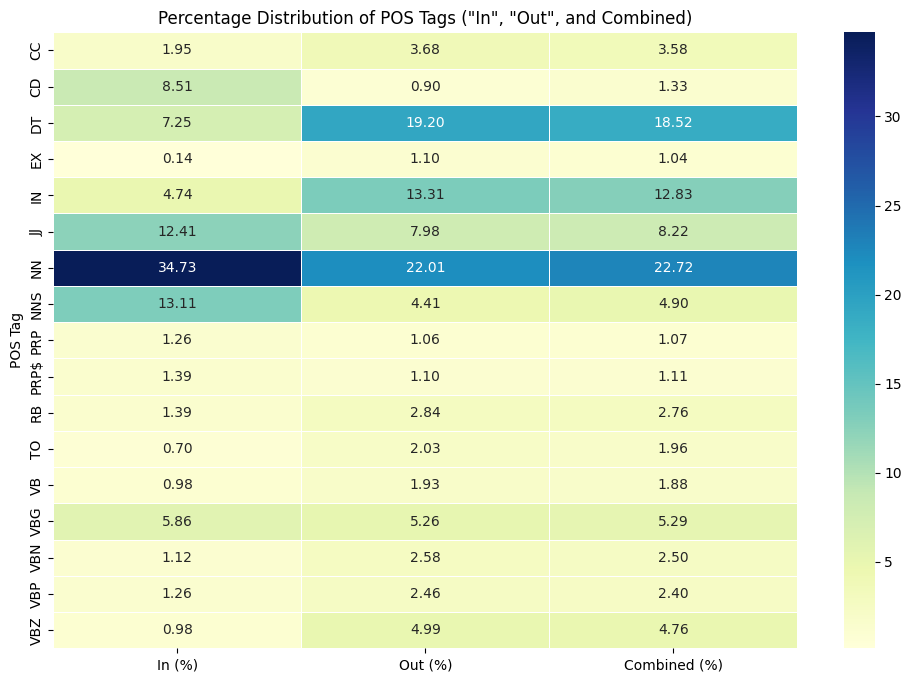

In [16]:

# Organize data by POS tag for 'in' and 'out' categories
pos_counts_in = {}
pos_counts_out = {}
pos_counts_combined = {}

for combine_word_pos_prob in df['combine_word_pos_prob']:
    for category, pos_probs in combine_word_pos_prob.items():
        for word, pos, prob in pos_probs:
            if category == 'in':
                if pos not in pos_counts_in:
                    pos_counts_in[pos] = 0
                pos_counts_in[pos] += 1
            elif category == 'out':
                if pos not in pos_counts_out:
                    pos_counts_out[pos] = 0
                pos_counts_out[pos] += 1

# Combine counts for both 'in' and 'out'
all_pos_tags = sorted(set(pos_counts_in.keys()).union(set(pos_counts_out.keys())))
for pos in all_pos_tags:
    pos_counts_combined[pos] = pos_counts_in.get(pos, 0) + pos_counts_out.get(pos, 0)

# Calculate percentage of each POS tag
def calculate_percentages(counts):
    total = sum(counts.values())
    return {pos: (count / total) * 100 for pos, count in counts.items()}

# Compute percentages
percentages_in = calculate_percentages(pos_counts_in)
percentages_out = calculate_percentages(pos_counts_out)
percentages_combined = calculate_percentages(pos_counts_combined)

# Create DataFrame for heatmap
heatmap_data = {
    'POS Tag': all_pos_tags,
    'In (%)': [percentages_in.get(pos, 0) for pos in all_pos_tags],
    'Out (%)': [percentages_out.get(pos, 0) for pos in all_pos_tags],
    'Combined (%)': [percentages_combined.get(pos, 0) for pos in all_pos_tags]
}

heatmap_df = pd.DataFrame(heatmap_data).set_index('POS Tag')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df[heatmap_df['Combined (%)']>1], annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title('Percentage Distribution of POS Tags ("In", "Out", and Combined)')
plt.show()

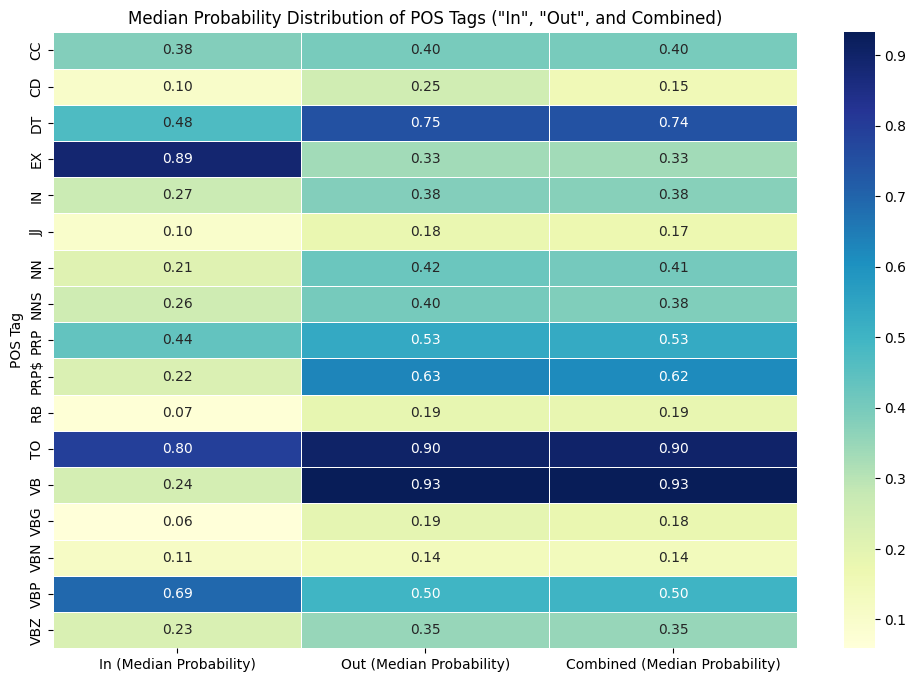

In [17]:
# Organize data by POS tag for 'in', 'out', and combined categories
pos_probs_in = {}
pos_probs_out = {}
pos_probs_combined = {}

for combine_word_pos_prob in df['combine_word_pos_prob']:
    for category, pos_probs in combine_word_pos_prob.items():
        for word, pos, prob in pos_probs:
            if category == 'in':
                if pos not in pos_probs_in:
                    pos_probs_in[pos] = []
                pos_probs_in[pos].append(prob)
            elif category == 'out':
                if pos not in pos_probs_out:
                    pos_probs_out[pos] = []
                pos_probs_out[pos].append(prob)

# Combine probabilities for both 'in' and 'out'
all_pos_tags = sorted(set(pos_probs_in.keys()).union(set(pos_probs_out.keys())))
for pos in all_pos_tags:
    combined_probs = pos_probs_in.get(pos, []) + pos_probs_out.get(pos, [])
    pos_probs_combined[pos] = combined_probs

# Calculate median probability of each POS tag
def calculate_median_probs(probs):
    return {pos: np.median(prob_list) if prob_list else 0 for pos, prob_list in probs.items()}

# Compute median probabilities
median_probs_in = calculate_median_probs(pos_probs_in)
median_probs_out = calculate_median_probs(pos_probs_out)
median_probs_combined = calculate_median_probs(pos_probs_combined)

# Create DataFrame for heatmap
heatmap_data = {
    'POS Tag': all_pos_tags,
    'In (Median Probability)': [median_probs_in.get(pos, 0) for pos in all_pos_tags],
    'Out (Median Probability)': [median_probs_out.get(pos, 0) for pos in all_pos_tags],
    'Combined (Median Probability)': [median_probs_combined.get(pos, 0) for pos in all_pos_tags]
}

median_heatmap_df = pd.DataFrame(heatmap_data).set_index('POS Tag')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(median_heatmap_df[heatmap_df['Combined (%)']>1], annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title('Median Probability Distribution of POS Tags ("In", "Out", and Combined)')
plt.show()